# Example Notebook For Associating Experimental Signals With The Carbon Network
Prior to running this notebook, the CarbonNetwork graphml file must be present in the build folder

In [1]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import networkx as nx
import os
import glob

from typing import List, Tuple

from tqdm.notebook import tqdm

# replace with submodules
import sys
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft
sys.path.insert(0,'/global/homes/b/bpb/repos/blink')
import blink

import analysis_tools as at

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


## Parameters
The next code block sets parameters that are used throughout the remainder of the notebook.

In [2]:
# experiment directory
## note: must follow Northen Lab file naming conventions and be converted to hdf5 format
# exp_dir  = '/global/cfs/cdirs/metatlas/raw_data/egsb/20240125_EB_MdR_101544-059_WAVESTAB3_20231222_EXP120A_C18-EP_USDAY72349'
# exp_dir = ['/global/cfs/cdirs/metatlas/raw_data/egsb/20231113_EB_SMK_107002-011_CenturyExp_20230414_EXP120A_C18-EP_USDAY72349',
        #    '/global/cfs/cdirs/metatlas/raw_data/jgi/20240112_JGI_MdR_109570-002_OMTSoil50g_Pilot_QEHF_C18_USDAY86082_CORRECTED']
# experiment directory
## note: must follow Northen Lab file naming conventions and be converted to hdf5 format

# tolerance in ppm between experimental signal and node mz
mz_ppm_tolerance = 5
peak_height_min = 1e4
num_datapoints_min = 10
# minimum MSMS score 
msms_score_min = 0.5

# minimum MSMS matching ion count
msms_matches_min = 3

# retention time range in minutes for feature finding
rt_range = [1, 700]

# tolerance in daltons used for calculating MS/MS similarity scores
frag_mz_tolerance = 0.05

In [3]:
from importlib import reload
at = reload(at)

In [4]:
df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/public_and_internal_files_with_massive_and_redu.tsv', sep='\t')
# df = df[df['SampleType']=='plant']
df = df[~df['buddy'].str.contains('qc',case=False)]
df = df[~df['buddy'].str.contains('blank',case=False)]
idx1 = (df['in_massive_dom_list'])# | df['keyword_DOM']
idx3 = df['buddy'].str.contains('rawdata_for_scn')
df = df[(idx3) | (idx1)] #  | (idx2)

files = df['buddy'].tolist()
len(files)

2258

In [12]:
# collect and merge required data and metadata
node_data = at.graph_to_df()
node_atlas = at.make_node_atlas(node_data, rt_range)
merged_node_data = at.merge_spectral_data(node_data)
# files_data = at.get_files_df(exp_dir)
# files = files_data['filename'].tolist()

INFO:root:Processing original_spectra.mgf
INFO:root:Processing nl_spectra.mgf


(6853, 9)
(6853, 9)


In [13]:
node_data.shape,merged_node_data.shape

((6853, 48), (6853, 66))

In [14]:
from importlib import reload
at = reload(at)
# get ms1 and ms2 data
# ms1_data = at.get_sample_ms1_data(node_atlas, files, mz_ppm_tolerance,peak_height_min,num_datapoints_min)
# max_ms1_data = at.get_best_ms1_rawdata(ms1_data,node_data)
# ms2_data = at.get_sample_ms2_data(files,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance,frag_mz_tolerance)
# max_ms2_data = at.get_best_ms2_rawdata(ms2_data)
# best_hits = at.get_best_ms1_ms2_combined(max_ms1_data,max_ms2_data)

from multiprocessing import Pool
# Define a helper function
def helper(file):
    return at.get_sample_ms2_data(file, merged_node_data, msms_score_min, msms_matches_min, mz_ppm_tolerance, frag_mz_tolerance)


# Convert the files list to a numpy array
files_array = np.array(files)

# Split the array into 100 chunks
chunks = np.array_split(files_array, 500)

# Print the first chunk
# Use the helper function in Pool().map()
with Pool(20) as p:
    results = p.map(helper, chunks)

# ms2_data = pd.concat(results)

In [15]:
ms2_data = pd.concat([pd.concat(r) for r in results if r is not None])

In [40]:
ms2_data

,query,ref,score,matches,best_match_method,node_id,lcmsrun_observed
0,0,1818,0.999682,3.0,score_nl,1306.0,/pscratch/sd/b/bpb/massive/v01/MSV000088543/cc...
1,0,1819,0.998791,3.0,score_nl,404.0,/pscratch/sd/b/bpb/massive/v01/MSV000088543/cc...
2,1,15,1.242407,16.0,score_or,82.0,/pscratch/sd/b/bpb/massive/v01/MSV000088543/cc...
3,1,17,1.232717,14.0,score_or,86.0,/pscratch/sd/b/bpb/massive/v01/MSV000088543/cc...
4,1,18,1.383419,25.0,score_or,90.0,/pscratch/sd/b/bpb/massive/v01/MSV000088543/cc...
...,...,...,...,...,...,...,...
242,176,2848,1.429878,4.0,score_nl,941.0,/global/cfs/cdirs/metatlas/projects/rawdata_fo...
243,177,11,0.983421,4.0,score_nl,2.0,/global/cfs/cdirs/metatlas/projects/rawdata_fo...
244,177,19,0.891255,3.0,score_nl,96.0,/global/cfs/cdirs/metatlas/projects/rawdata_fo...
245,177,28,0.957497,3.0,score_nl,1262.0,/global/cfs/cdirs/metatlas/projects/rawdata_fo...


# per experiment
# drop duplicates on each filename
# iteratively add properties to try and find orthogonal support

In [42]:
ms2_data.loc[ms2_data['node_id']=='1306.0','lcmsrun_observed'].unique()

<StringArray>
[  '/pscratch/sd/b/bpb/massive/v01/MSV000088543/ccms_peak/raw_data/20181019_JJ_KZ_Switchgrass_Greenhouse_Rhizo1_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_Rhizo-12C-C-Bot-T2-1-E216_IR002_352.h5',
   '/pscratch/sd/b/bpb/massive/v01/MSV000088543/ccms_peak/raw_data/20181019_JJ_KZ_Switchgrass_Greenhouse_Rhizo1_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_Rhizo-12C-C-Bot-T3-1-E226_IR002_021.h5',
   '/pscratch/sd/b/bpb/massive/v01/MSV000088543/ccms_peak/raw_data/20181019_JJ_KZ_Switchgrass_Greenhouse_Rhizo1_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_Rhizo-12C-C-Mid-T2-1-E159_IR002_030.h5',
   '/pscratch/sd/b/bpb/massive/v01/MSV000088543/ccms_peak/raw_data/20181019_JJ_KZ_Switchgrass_Greenhouse_Rhizo1_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_Rhizo-12C-C-Mid-T3-2-E148_IR002_260.h5',
   '/pscratch/sd/b/bpb/massive/v01/MSV000088543/ccms_peak/raw_data/20181019_JJ_KZ_Switchgrass_Greenhouse_Rhizo1_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_Rhizo-12C-C-Top-T2-1-E026_IR002_120.h5',
   '/pscratch/sd

In [16]:
class_col = 'class_results_propagated'
d = pd.merge(ms2_data,node_data,on='node_id',how='left')
cols = ['node_id','inchi_key_identity','smiles_identity','class_results','superclass_results',class_col] + ['score','matches','best_match_method']
d = d[cols]
sum(pd.isna(d['inchi_key_identity'])),sum(pd.notna(d['inchi_key_identity']))

(599346, 420746)

In [44]:
# d = pd.merge(ms2_data,node_data[pd.notna(node_data['inchi_key_identity'])],on='node_id',how='left')
frequency = ms2_data.sort_values('score',ascending=False).drop_duplicates('lcmsrun_observed').groupby('node_id')['score'].count().to_frame()
frequency.reset_index(inplace=True)
frequency.columns = ['node_id','frequency']
d = pd.merge(node_data,frequency,on='node_id',how='left')
d = d[pd.notna(d['inchi_key_identity'])]
d = d[d['frequency']>0]
cols = ['node_id','inchi_key_identity','smiles_identity','frequency','class_results','superclass_results']
d = d[cols]
d.drop_duplicates(inplace=True)
d

,node_id,inchi_key_identity,smiles_identity,frequency,class_results,superclass_results
1,0.0,SAVLIIGUQOSOEP-UHFFFAOYSA-N,CCCCCCCC(O)=NCC(=O)O,2.0,Oxo fatty acids,Fatty Acids and Conjugates
10,8.0,KKEYFWRCBNTPAC-UHFFFAOYSA-N,O=C(O)c1ccc(C(=O)O)cc1,95.0,Simple phenolic acids,Phenolic acids (C6-C1)
11,2.0,BCEQKAQCUWUNML-UHFFFAOYSA-N,O=C(O)c1ccc(O)c(C(=O)O)c1,52.0,Simple phenolic acids,Phenolic acids (C6-C1)
14,48.0,WVDGHGISNBRCAO-UHFFFAOYSA-N,O=C(O)c1cccc(C(=O)O)c1O,29.0,Simple phenolic acids,Phenolic acids (C6-C1)
15,82.0,UYEMGAFJOZZIFP-UHFFFAOYSA-N,O=C(O)c1cc(O)cc(O)c1,12.0,Simple phenolic acids,Phenolic acids (C6-C1)
...,...,...,...,...,...,...
3202,1123.0,RHVWQVSLVMXMBR-CLTKARDFSA-N,CC/C=C\CC1=C(CCCCCCCC(=O)O)CCC1=O,9.0,NaN,Octadecanoids
3285,1196.0,KCDXJAYRVLXPFO-UHFFFAOYSA-N,COc1cc(C=O)cc(OC)c1O,1.0,Simple phenolic acids,Phenolic acids (C6-C1)
3320,1229.0,YPIDZFLQKNEKRA-UHFFFAOYSA-N,COc1cc(O)c(C)c(O)c1,8.0,Acyl phloroglucinols,Phloroglucinols
3322,1232.0,ISFMXVMWEWLJGJ-UHFFFAOYSA-N,CC1=CC2(O)OC3(CC2=C(C)C)C(C)CCC13,1.0,Eremophilane sesquiterpenoids,Sesquiterpenoids


In [39]:
class_col = 'class_results_propagated'
# d = pd.merge(ms2_data,node_data,on='node_id',how='left')
frequency = ms2_data.groupby('node_id')['score'].count().to_frame()
frequency.reset_index(inplace=True)
frequency.columns = ['node_id','frequency']
d = pd.merge(node_data,frequency,on='node_id',how='right')
cols = ['node_id','inchi_key_identity','smiles_identity','frequency','class_results','superclass_results',class_col]
d = d[cols]
d = d[d['frequency']>0]
d = d[pd.notna(d[class_col])]
d.drop_duplicates(subset='node_id',inplace=True)
d.sort_values(ascending=False,by='frequency',inplace=True)
# fig,ax = plt.subplots()
# bins = np.linspace(0,4,100)
# d.loc[pd.notna(d['inchi_key_identity']),'frequency'].apply(np.log10).hist(bins=bins,ax=ax)
# d.loc[pd.isna(d['inchi_key_identity']),'frequency'].apply(np.log10).hist(bins=bins,ax=ax)
class_results = d.groupby([class_col])['frequency'].agg(['count','mean','median'])
class_results.reset_index(inplace=True)
class_results.sort_values(ascending=False,by='median',inplace=True)
class_results.head(20)

,class_results_propagated,count,mean,median
24,Bisabolane sesquiterpenoids,3,1402.000000,1643.0
40,Daucane sesquiterpenoids,2,1463.500000,1463.5
84,Leukotrienes,4,1007.250000,1309.5
72,Iphionane sesquiterpenoids,1,1261.000000,1261.0
144,Serrulatane and Biflorane diterpenoids,1,1260.000000,1260.0
154,Thromboxanes,3,1107.000000,1215.0
27,Cadinane sesquiterpenoids,2,1200.500000,1200.5
22,Benzoquinones,1,1176.000000,1176.0
53,Fatty alcohols,1,1138.000000,1138.0
152,Tetracyclic diterpenoids,3,906.333333,1131.0


In [149]:
ms2_data.shape

(161719, 7)

In [24]:
cols = ['inchi_key_identity','smiles_identity']
data = node_data[cols].copy()
data.drop_duplicates('inchi_key_identity',inplace=True)
data = data[pd.notna(data['inchi_key_identity'])]
data.rename(columns={'inchi_key_identity':'inchi_key','smiles_identity':'smiles'},inplace=True)
data.head()
# sys.path.insert(0,'.')
from get_compound_descriptors import calc_descriptor_df
# from importlib import reload
# gcd = reload(gcd)
data = calc_descriptor_df(data)

In [45]:
d = pd.merge(d,data,left_on='inchi_key_identity',right_on='inchikey',how='left')
d

,node_id,inchi_key_identity,smiles_identity,frequency,class_results,superclass_results,inchikey,property: exactmw,property: amw,property: lipinskiHBA,...,descriptor: fr_sulfide,descriptor: fr_sulfonamd,descriptor: fr_sulfone,descriptor: fr_term_acetylene,descriptor: fr_tetrazole,descriptor: fr_thiazole,descriptor: fr_thiocyan,descriptor: fr_thiophene,descriptor: fr_unbrch_alkane,descriptor: fr_urea
0,0.0,SAVLIIGUQOSOEP-UHFFFAOYSA-N,CCCCCCCC(O)=NCC(=O)O,2.0,Oxo fatty acids,Fatty Acids and Conjugates,SAVLIIGUQOSOEP-UHFFFAOYSA-N,201.136493,201.266,4.0,...,0,0,0,0,0,0,0,0,3,0
1,8.0,KKEYFWRCBNTPAC-UHFFFAOYSA-N,O=C(O)c1ccc(C(=O)O)cc1,95.0,Simple phenolic acids,Phenolic acids (C6-C1),KKEYFWRCBNTPAC-UHFFFAOYSA-N,166.026609,166.132,4.0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,BCEQKAQCUWUNML-UHFFFAOYSA-N,O=C(O)c1ccc(O)c(C(=O)O)c1,52.0,Simple phenolic acids,Phenolic acids (C6-C1),BCEQKAQCUWUNML-UHFFFAOYSA-N,182.021523,182.131,5.0,...,0,0,0,0,0,0,0,0,0,0
3,48.0,WVDGHGISNBRCAO-UHFFFAOYSA-N,O=C(O)c1cccc(C(=O)O)c1O,29.0,Simple phenolic acids,Phenolic acids (C6-C1),WVDGHGISNBRCAO-UHFFFAOYSA-N,182.021523,182.131,5.0,...,0,0,0,0,0,0,0,0,0,0
4,82.0,UYEMGAFJOZZIFP-UHFFFAOYSA-N,O=C(O)c1cc(O)cc(O)c1,12.0,Simple phenolic acids,Phenolic acids (C6-C1),UYEMGAFJOZZIFP-UHFFFAOYSA-N,154.026609,154.121,4.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,1123.0,RHVWQVSLVMXMBR-CLTKARDFSA-N,CC/C=C\CC1=C(CCCCCCCC(=O)O)CCC1=O,9.0,NaN,Octadecanoids,RHVWQVSLVMXMBR-CLTKARDFSA-N,292.203845,292.419,3.0,...,0,0,0,0,0,0,0,0,4,0
166,1196.0,KCDXJAYRVLXPFO-UHFFFAOYSA-N,COc1cc(C=O)cc(OC)c1O,1.0,Simple phenolic acids,Phenolic acids (C6-C1),KCDXJAYRVLXPFO-UHFFFAOYSA-N,182.057909,182.175,4.0,...,0,0,0,0,0,0,0,0,0,0
167,1229.0,YPIDZFLQKNEKRA-UHFFFAOYSA-N,COc1cc(O)c(C)c(O)c1,8.0,Acyl phloroglucinols,Phloroglucinols,YPIDZFLQKNEKRA-UHFFFAOYSA-N,154.062994,154.165,3.0,...,0,0,0,0,0,0,0,0,0,0
168,1232.0,ISFMXVMWEWLJGJ-UHFFFAOYSA-N,CC1=CC2(O)OC3(CC2=C(C)C)C(C)CCC13,1.0,Eremophilane sesquiterpenoids,Sesquiterpenoids,ISFMXVMWEWLJGJ-UHFFFAOYSA-N,234.161980,234.339,2.0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
import pingouin as pg
cols = [c for c in d.columns if c.startswith('property')]
cols = cols + [c for c in d.columns if c.startswith('descriptor')]
out = []
for c in cols:
    d[c] = d[c].astype(float)
    x = np.log10(d['frequency'])
    # x = d['frequency']
    y = d[c]
    idx = pd.notna(x) & pd.notna(y)
    corr = pg.corr(x[idx],y[idx],method='spearman')
    r = corr["r"].values[0]
    p = corr["p-val"].values[0]
    if p < 0.05:
        # if 'rings' in c.lower():
        out.append((c,r,p))
        # print(f'{c}: r={corr["r"].values[0]:.2f}, p={corr["p-val"].values[0]:.2e}')
    
    # print(f'{c}: r={r:.2f}, p={p:.2e}')
out = pd.DataFrame(out,columns=['descriptor','r','p'])
out.sort_values('r',inplace=True)
out.reset_index(drop=True,inplace=True)
out.tail(30)

,descriptor,r,p
14,descriptor: Chi0v,-0.176165,0.021564
15,property: NumUnspecifiedAtomStereoCenters,-0.176139,0.021583
16,property: chi4n,-0.176137,0.021584
17,descriptor: Chi4n,-0.176137,0.021584
18,descriptor: Chi0n,-0.173716,0.023481
19,property: chi0n,-0.173716,0.023481
20,descriptor: fr_bicyclic,-0.172233,0.024711
21,descriptor: Chi1v,-0.170104,0.026575
22,property: chi1v,-0.170104,0.026575
23,descriptor: MolMR,-0.167289,0.029222


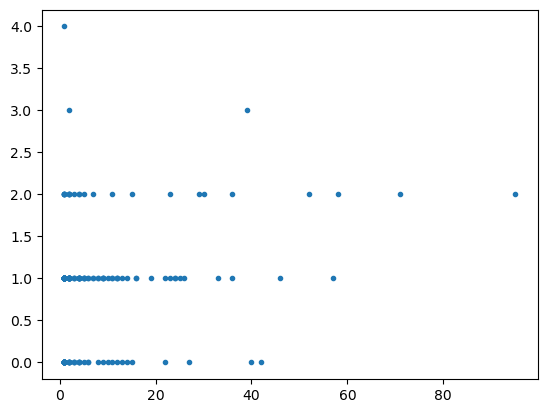

In [58]:
import seaborn as sns
# my_prop = 'property: NumUnspecifiedAtomStereoCenters'
my_prop = 'descriptor: fr_COO2'
x = d['frequency']
y = d[my_prop]
idx = pd.notna(x) & pd.notna(y)
x = x[idx]
y = y[idx]
# bins = np.linspace(x.min(),x.max(),20)
t = pd.DataFrame()
t['x'] = x
t['y'] = y
t['descriptor'] = my_prop
fig,ax = plt.subplots()
ax.plot(x,y,'.')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


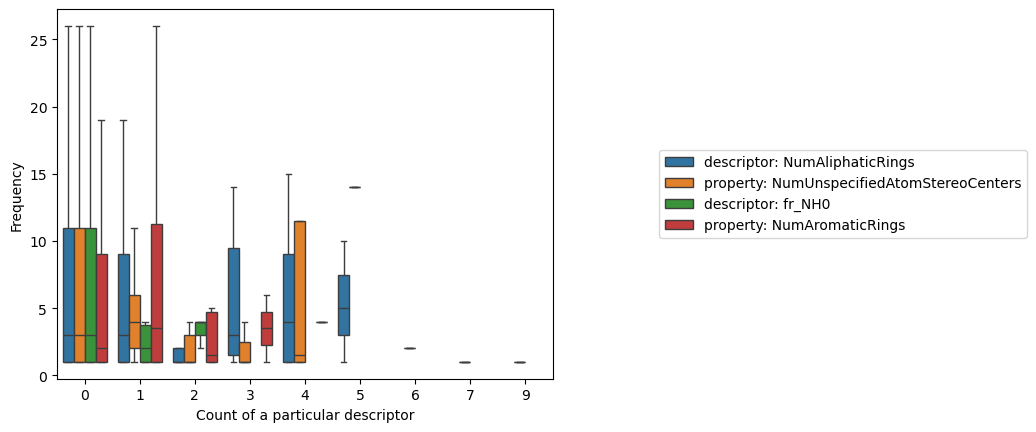

In [49]:
import seaborn as sns
my_prop = 'descriptor: NumAliphaticRings'
x = d['frequency']
y = d[my_prop]
idx = pd.notna(x) & pd.notna(y)
x = x[idx]
y = y[idx]
# bins = np.linspace(x.min(),x.max(),20)
t = pd.DataFrame()
t['x'] = x
t['y'] = y
t['descriptor'] = my_prop

for my_prop in ['property: NumUnspecifiedAtomStereoCenters','descriptor: fr_NH0','property: NumAromaticRings']:#,'descriptor: fr_allylic_oxid','property: FractionCSP3']:
    x = d['frequency']
    y = d[my_prop]
    idx = pd.notna(x) & pd.notna(y)
    x = x[idx]
    y = y[idx]
    # bins = np.linspace(x.min(),x.max(),20)
    t2 = pd.DataFrame()
    t2['x'] = x
    t2['y'] = y
    t2['descriptor'] = my_prop

    t = pd.concat([t,t2])

t.reset_index(drop=True,inplace=True)
t['x'] = t['x']#.apply(lambda x: x**0.5)
t['y'] = t['y'].astype(int)
fig,ax = plt.subplots()
sns.boxplot(data=t,x='y',y='x',hue='descriptor',showfliers=False,ax=ax)
# idx = x > 500 # not eaten?    
# fig,ax = plt.subplots()
# sns.histplot(y[idx],ax=ax,bins=bins,label='Common',stat='density')
# idx = x < 50 #eaten?
# sns.histplot(y[idx],ax=ax,bins=bins,label='Rare',stat='density')


# Add a legend
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Move the legend outside the plot area
legend.set_bbox_to_anchor((1.2, 0.5))
ax.set_xlabel('Count of a particular descriptor')
ax.set_ylabel('Frequency')
# ax.set_yscale('log')
# Show the plot
plt.show()

In [89]:
t

,x,y,descriptor
0,1.995635,0.0,descriptor: NumAliphaticHeterocycles
1,3.442166,0.0,descriptor: NumAliphaticHeterocycles
2,3.599556,1.0,descriptor: NumAliphaticHeterocycles
3,3.115611,0.0,descriptor: NumAliphaticHeterocycles
4,2.181844,0.0,descriptor: NumAliphaticHeterocycles
...,...,...,...
326,1.176091,1.0,descriptor: NumAliphaticHeterocycles
327,0.301030,0.0,descriptor: NumAliphaticHeterocycles
328,0.778151,1.0,descriptor: NumAliphaticHeterocycles
329,0.301030,1.0,descriptor: NumAliphaticHeterocycles


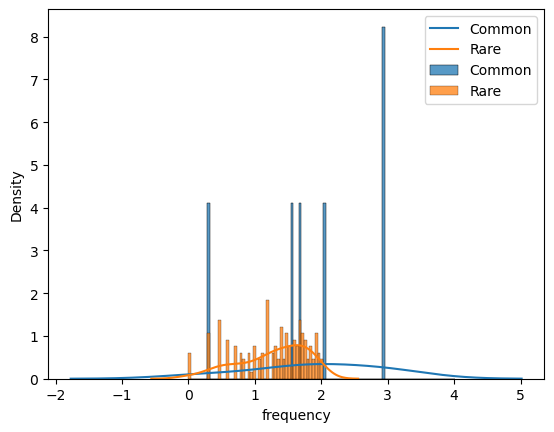

In [69]:
import seaborn as sns
my_prop = 'descriptor: NumAliphaticHeterocycles'
x = d['frequency']
x = np.log10(x)
y = d[my_prop]
idx = pd.notna(x) & pd.notna(y)
x = x[idx]
y = y[idx]
idx = y >=2
fig,ax = plt.subplots()
bins = np.linspace(x.min(),x.max(),100)
sns.histplot(x[idx],ax=ax,bins=bins,label='Common',stat='density')
sns.kdeplot(x[idx],ax=ax,label='Common')#,stat='density')
idx = x < 2 #eaten?
sns.histplot(x[idx],ax=ax,bins=bins,label='Rare',stat='density')
sns.kdeplot(x[idx],ax=ax,label='Rare')#,stat='density')

plt.legend()

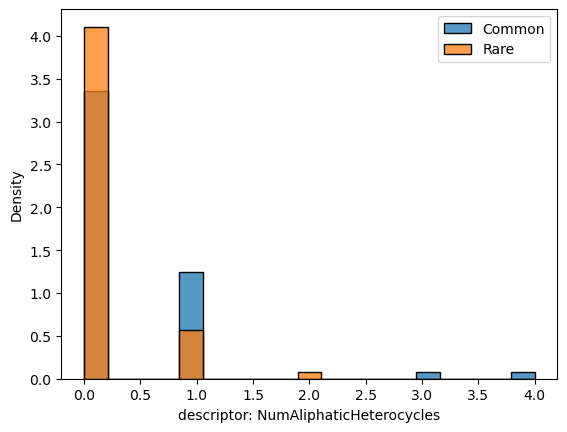

In [70]:
import seaborn as sns
my_prop = 'descriptor: NumAliphaticHeterocycles'
x = d['frequency']
# x = np.log10(x)
y = d[my_prop]
idx = pd.notna(x) & pd.notna(y)
x = x[idx]
y = y[idx]
idx = x > 500 # not eaten?    
fig,ax = plt.subplots()
bins = np.linspace(y.min(),y.max(),20)
sns.histplot(y[idx],ax=ax,bins=bins,label='Common',stat='density')
idx = x < 50 #eaten?
sns.histplot(y[idx],ax=ax,bins=bins,label='Rare',stat='density')
plt.legend()

<Axes: >

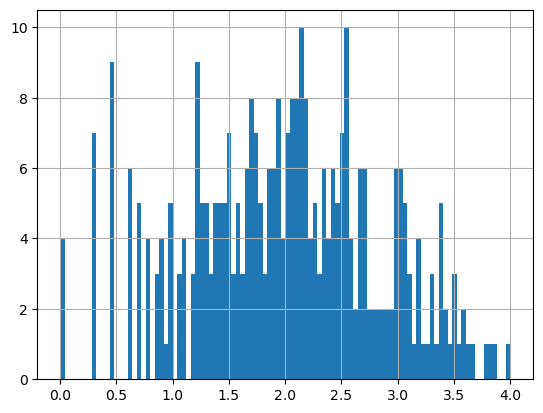

In [44]:
fig,ax = plt.subplots()
frequency = ms2_data.groupby('node_id')['score'].count().apply(np.log10)
frequency.hist(ax=ax,bins=100)

In [ ]:
ms2_data.to_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/backup_ms2_data.pkl')

In [ ]:
best_hits = best_hits[best_hits['peak_area']>1e4]
best_hits[pd.notna(best_hits['ms2_score'])]

In [ ]:
def make_output_df(node_data,best_hits,filename='output.csv'):
    output = node_data.copy()
    output.set_index('node_id',inplace=True)
    output = output.join(best_hits.set_index('node_id'),rsuffix='_best_hit',how='left')
    output.to_csv(filename)
    return output
make_output_df(node_data,best_hits,filename='BestHits_PlantData.csv')

In [ ]:
d_sample = ms1_data.pivot_table(index='node_id',columns=['lcmsrun_observed'],values='peak_area',aggfunc='mean',fill_value=300)
d_sample.to_csv('PeakArea_PlantData.csv') 
